<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <img src="images/Xlogo.png" alt="Transposition of a vector" title="Vector transposition" width="115" style="float: left;">
  <p style=" text-align: center; font-size: 32px;">   
   <strong> Deep Learning in Finance MAP548 </strong></p>
  <p style=" text-align: center; font-size: 25px;"><strong> Project 1 -  Deep pricing and calibration </strong></p>
  <p style=" text-align: center; font-size: 20px;"> Eduardo Abi Jaber </p>
</header>

# <font color='red'>PLEASE ENTER YOUR FULL NAMES HERE:</font>



- MANSARD Diane
- POTTIER Clément

<font color='red'>**DEADLINE: March 2 (5:00 pm)**</font>

<font color='red'>**PLease send both pdf ipynb files with name : Name1_Name2_Project1**</font>

# The two factor Bergomi model

The two factor Bergomi Model (L Bergomi, 2005) under the risk-neutral filtered probability space $(\Omega, \mathcal F,(\mathcal F_t)_{t\geq 0}, \mathbb Q )$  has the following dynamics:


\begin{equation}
  \begin{aligned}
    dS_t &= S_t\sqrt{V_t}dB_t, \quad S_0>0;\\
    X_t &= X_t^1 + X_t^2,\\
    V_t &= \xi \exp{\left(X_t-\frac{1}{2} \mathbb{V}[X_t] \right)},\\
      X_t^i &=  \eta_i\int_0^t e^{-\kappa_i(t-s)} dW_s,
  \end{aligned}
  \end{equation}

where $ B=\rho W + \sqrt{1-\rho^2} W^{\perp}$ with $(W,W^{\perp})$ a two-dimensional Brownian motion, $\rho \in [-1,1]$.

$X_t^i$ is a Ornstein–Uhlenbeck (Gaussian) process such that $X_t^i \sim \mathcal{N}(0, \eta_i^2\frac{(1-e^{-2\kappa_i t})}{2\kappa_i})$. Note that both $X^1$ and $X^2$ are driven by the same Brownian motion.

Recall $\mathbb V[(X+Y)] = \mathbb V[X] + \mathbb V[Y] + 2\mathbb {COV}[X,Y]$.

In addition, we fix $\kappa_2=2.6$, thus there are in total five calibratable model parameters: $(\xi, \kappa_1, \eta_1, \eta_2, \rho)$.

We are interested in computing the price of European style contingent claims, with payoff $g(S_T)$ for some function $g$:
$$
C_t = \mathbb{E} \left[g(S_T) \vert \mathcal F_t) \right].
$$

For European vanilla call options, with $g(x) = (x-K)^{+}$ with strike $K$; no closed form formula to compute $g(S_T)$

Suggested range of model parameters for training:

$\xi \in [0.03,0.25], \kappa_1 \in [10,60], \eta_1 \in [5,35],\eta_2 \in [1,5],\rho \in [-0.9,-0.1]$

# Your task

Inspired by the deep pricer for the one factor Bergomi model. Implement a deep pricer for the two factor Bergomi model. You have to generate your own training set using a scheme of your choice that you have to detail (use the fixed grid for strikes and maturities below).

Once your NN is trained, showcase the train and test error, and perform a calibration on the market implied volatility surface that was used in the one factor Bergomi and comment. 

Also provide/display the output prices of the NN of the set of parameters set 1, 2 and 3 below. 

You have to provide a notebook that compiles, together with the trained weights of your Neural Networks that we can load with the command: *model_iv.load_weights('2FBergomiNNWeights.h5')*. 

(!) The actual training of NN is not difficult, the difficult part is to get good data (and lots of it), so be careful about your simulation schemes (training might require a larger dataset than for 1 factor bergomi).

In [93]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


from tqdm.notebook import tqdm

## Let's start simulating Xt1 and Xt2 using a recursive method

##### [We first study how to simulate one price, to then implement at a larger scale.]

Define the process for a 1-factor model:

$$
\widetilde X_t = e^{\kappa t}X_t = \int_0^t e^{\kappa s} dW_s,
$$

so that

$$
\widetilde X_{t_{j+1}} = \widetilde X_{t_j} + \int_{t_{j}}^{t_{j+1}}e^{\kappa s} dW_s =  \
    \widetilde X_{t_j}+\sqrt{\frac{e^{2 \kappa t_{j+1}}-e^{2 \kappa t_{j}}}{2\kappa}}Y_j,
$$

with $t_0 = 0, \quad t_N = T, \quad Y_i  \sim \mathcal{N}(0, 1)$ iid. Thus we first simulate $\widetilde X_{t_{j+1}}$ and then convert back to $X_t$ by:

$$
 X_t = e^{-\kappa t} \widetilde X_t.
$$

We then finally multiply by the corresponding eta to get the final value of the process for each Xt.

In [94]:
xi, kappa_1, eta_1, eta_2, rho, = 0.14, 35, 20, 3, -0.5
kappa_2 = 2.6
T = 2
n_steps = 1000 # number of time steps
N_sims = 50 # number of simulations for Monte Carlo 

dt = T/n_steps
tt = np.linspace(0., T, n_steps + 1)

In [95]:
times_to_find = [0.1,0.3,0.6,0.9,1.2,1.5,1.8,2.0 ] # list of the value to search for

indices = {time: np.argmin(np.abs(tt - time)) for time in times_to_find} # si approx numérique prend le plus proche, mieux pour stocker les indices: 

for time, index in indices.items():
    print(f"Time interval of {time}:", f"index {index} of the matrix tt")

Time interval of 0.1: index 50 of the matrix tt
Time interval of 0.3: index 150 of the matrix tt
Time interval of 0.6: index 300 of the matrix tt
Time interval of 0.9: index 450 of the matrix tt
Time interval of 1.2: index 600 of the matrix tt
Time interval of 1.5: index 750 of the matrix tt
Time interval of 1.8: index 900 of the matrix tt
Time interval of 2.0: index 1000 of the matrix tt


In [96]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

w1 = gen_bm_path(n_steps,N_sims)

In [97]:
# Simulation of Xt1
exp1_Xt1 = np.exp(kappa_1*tt[1:])
exp2_Xt1 = np.exp(2*kappa_1*tt)

diff_exp2_Xt1 = np.diff(exp2_Xt1)
std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt1 = exp1_Xt1[:,np.newaxis]
Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
Xt1 = eta_1*Xt1

In [98]:
# Simulation of Xt2
exp1_Xt2 = np.exp(kappa_2*tt[1:])
exp2_Xt2 = np.exp(2*kappa_2*tt)

diff_exp2_Xt2 = np.diff(exp2_Xt2)
std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
exp1_Xt2 = exp1_Xt2[:,np.newaxis]
Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
Xt2 = eta_2*Xt2

In [99]:
# Creation of Xt
Xt = Xt1 + Xt2

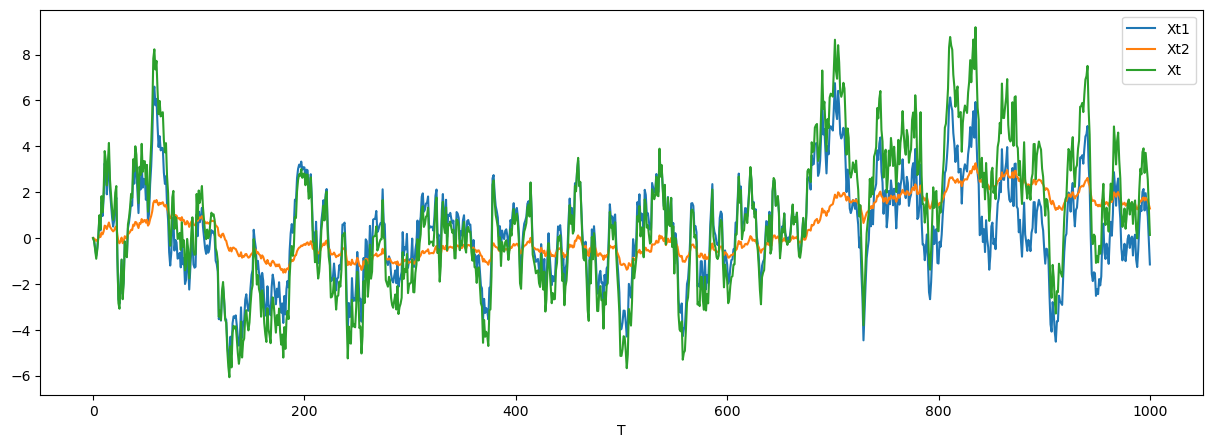

In [100]:
i_ind = 1
plt.figure(figsize=(15,5))
plt.plot(Xt1[:,i_ind],label='Xt1')
plt.plot(Xt2[:,i_ind],label='Xt2')
plt.plot(Xt[:,i_ind],label='Xt')
plt.xlabel('T')
plt.legend()
plt.show()

## Simulation of Vt and St with fixed parameters

The variance is computed as follow, we use the properties of the ItÔ intergrals :

$
\mathbb{V}[X_t] = \mathbb{V}[X_t^1] + \mathbb{V}[X_t^2] + 2 \mathbb{COV}[X_t^1, X_t^2]
$

$
\mathbb{V}[X_t] = \eta_1 \int_0^t e^{-\kappa_1 (t-s)} dW_s + \eta_2 \int_0^t e^{-\kappa_2 (t-s)} dW_s + 2\eta_1 \eta_2 \int_0^t e^{-\kappa_1 (t-s)} e^{-\kappa_2 (t-s)} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2 \kappa_2 t}}{2 \kappa_2} + \eta_1 \eta_2 e^{-t(\kappa_1 + \kappa_2)}\int_0^t e^{(\kappa_1 + \kappa_2)s} ds
$

$
\mathbb{V}[X_t] = \eta_1^2 \frac{1 - e^{-2\kappa_1 t}}{2\kappa_1} + \eta_2^2 \frac{1 - e^{-2\kappa_2 t}}{2\kappa_2} + \eta_1 \eta_2 \frac{1 - e^{-t(\kappa_1 + \kappa_2)}}{\kappa_1 + \kappa_2}
$


In [101]:
var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
var = var1 + var2 + 2*covar

Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis]) #variance calculated for each time step 

In [102]:
w1 = gen_bm_path(n_steps,N_sims)
w2 = gen_bm_path(n_steps,N_sims)

In [103]:
S0 = 100
r = 0.02 

log_S = np.ones(N_sims).reshape(1,-1)*np.log(S0)
epochs_iter_j = tqdm(range(n_steps), desc="iteration", miniters=2000)
for j in epochs_iter_j:
    log_S_next = log_S[j]-0.5*Vt[j]*dt+np.sqrt(Vt[j]*dt)*\
        (rho*w1[j]+np.sqrt(1-rho**2)*w2[j]) 
    log_S=np.append(log_S,log_S_next.reshape(1,-1),axis=0)

S = np.exp(log_S)

iteration:   0%|          | 0/1000 [00:00<?, ?it/s]

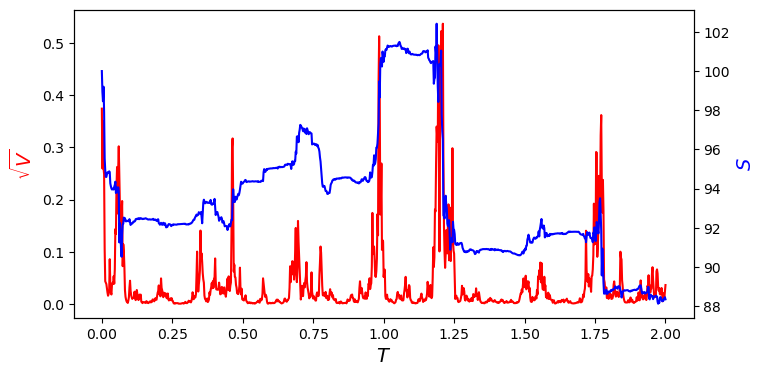

In [104]:
i_ind = 4 # The 4-th simulation
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot()
ax2 = ax.twinx()
lns2 = ax2.plot(tt,np.array(S[:,i_ind]), '-b',label = r'$S$')
lns1 = ax.plot(tt,np.sqrt(Vt[:,i_ind]), 'r',ls='-', label = r'$\sqrt{V}$')
labs = [l.get_label() for l in lns2+lns1]
ax.set_xlabel(r"$T$",size=14)
ax.set_ylabel(r'$\sqrt{V}$', color='red',size=14)
ax2.set_ylabel(r'$S$', color='blue',size=14)
plt.show()

## Let's now compute the prices of the option with the Monte Carlo method

With K=100 and T=2, the option price is:

In [105]:
K = 100
price = np.exp(-r*T) * np.mean(np.maximum(S[-1] - K, 0)) #Do the average of the payoffs of all the simulations
print(f"The option payoff is {price:.2f}")

The option payoff is 10.02


With K=100 and the requested time intervals:

In [106]:
for time, index in indices.items():
    price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - K, 0))
    print(f"The option payoff at time {time} is {price:.2f}")

The option payoff at time 0.1 is 3.10
The option payoff at time 0.3 is 3.69
The option payoff at time 0.6 is 4.18
The option payoff at time 0.9 is 9.00
The option payoff at time 1.2 is 8.06
The option payoff at time 1.5 is 7.75
The option payoff at time 1.8 is 9.03
The option payoff at time 2.0 is 10.42


Option prices at different strikes:

In [107]:
strikes=np.array([0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5 ])*S0

doit-on calibrer tous les prix avec exp(r(T-t)) ?

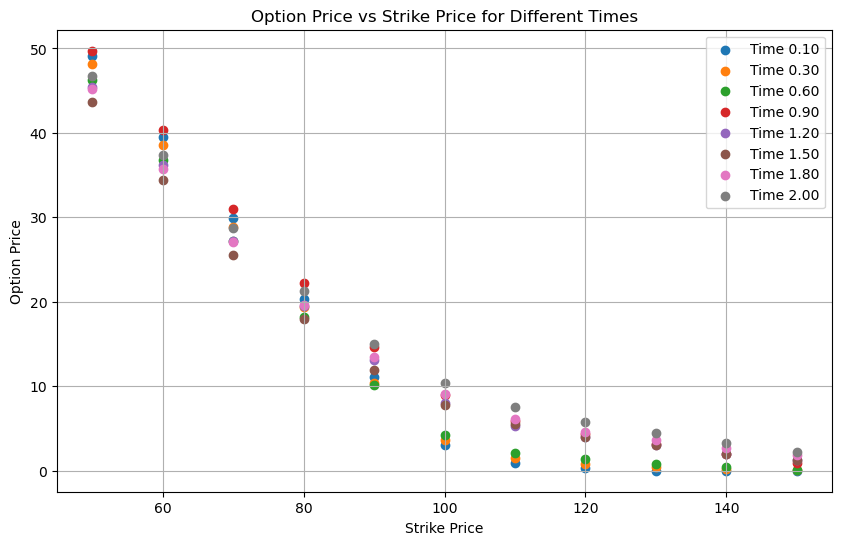

In [108]:
prices = {}

for time, index in indices.items():
    prices[time] = []
    for strike in strikes:
        price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0))
        prices[time].append((strike, price))

# Plot the results
plt.figure(figsize=(10, 6))
for time, prices_data in prices.items():
    strikes, prices_values = zip(*prices_data)
    plt.scatter(strikes, prices_values, label=f'Time {time:.2f}')

plt.xlabel('Strike Price')
plt.ylabel('Option Price')
plt.title('Option Price vs Strike Price for Different Times')
plt.legend()
plt.grid(True)
plt.show()

The option price decreases when the strike price increases, which is an encouraging sign that our simulation makes sense. 

## Let's implement the result in an array 

In [109]:
parameters = [xi, kappa_1, eta_1, eta_2, rho]
x = np.array(parameters).reshape(1, -1) 
x.shape


(1, 5)

In [110]:
values_list = [value for sublist in prices.values() for value in sublist]
y = np.array(values_list)

y.shape 

(88, 2)

In [111]:
print(y)

[[5.00000000e+01 4.91631750e+01]
 [6.00000000e+01 3.95360456e+01]
 [7.00000000e+01 2.99089162e+01]
 [8.00000000e+01 2.03699709e+01]
 [9.00000000e+01 1.11279266e+01]
 [1.00000000e+02 3.09676409e+00]
 [1.10000000e+02 8.85718009e-01]
 [1.20000000e+02 3.27074101e-01]
 [1.30000000e+02 0.00000000e+00]
 [1.40000000e+02 0.00000000e+00]
 [1.50000000e+02 0.00000000e+00]
 [5.00000000e+01 4.82114428e+01]
 [6.00000000e+01 3.85457277e+01]
 [7.00000000e+01 2.88800127e+01]
 [8.00000000e+01 1.93956460e+01]
 [9.00000000e+01 1.03853263e+01]
 [1.00000000e+02 3.68955514e+00]
 [1.10000000e+02 1.46758927e+00]
 [1.20000000e+02 8.53060819e-01]
 [1.30000000e+02 4.66432217e-01]
 [1.40000000e+02 2.34093623e-01]
 [1.50000000e+02 4.07793219e-02]
 [5.00000000e+01 4.62878906e+01]
 [6.00000000e+01 3.67584846e+01]
 [7.00000000e+01 2.72350101e+01]
 [8.00000000e+01 1.82231492e+01]
 [9.00000000e+01 1.01787366e+01]
 [1.00000000e+02 4.17909554e+00]
 [1.10000000e+02 2.07830667e+00]
 [1.20000000e+02 1.42843007e+00]
 [1.300000

# Sample IV surface values

In [112]:
N=40000
N_sims = 500
kappa_2 = 2.
T = 2
n_steps = 1000
dt = T / n_steps
S0 = 100
tt = np.linspace(0, T, n_steps + 1)
strikes = np.array([0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5])*S0
indices = {time: np.argmin(np.abs(tt - time)) for time in [0.1, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.0]}
r = 0.02

In [113]:
np.random.seed(42)

def gen_bm_path(n_steps,N_sims):
    w1 = np.random.normal(0, 1, (n_steps, N_sims))
    return w1

In [114]:
X_data = np.array([]).reshape(0, 5)
y_data = np.array([]).reshape(0, 88)

for i in tqdm(range(N), desc="Avancement", unit="iter"):
    xi = np.random.uniform(0.03, 0.25)
    kappa_1 = np.random.uniform(10, 60)
    eta_1 = np.random.uniform(5, 35)
    eta_2 = np.random.uniform(1, 5)
    rho = np.random.uniform(-0.9, -0.1)
    
    
    w1 = gen_bm_path(n_steps, N_sims)
    w2 = gen_bm_path(n_steps, N_sims)
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    log_S = np.ones(N_sims).reshape(1,-1) * np.log(S0)
    
    # sim Xt1
    exp1_Xt1 = np.exp(kappa_1*tt[1:])
    exp2_Xt1 = np.exp(2*kappa_1*tt)

    diff_exp2_Xt1 = np.diff(exp2_Xt1)
    std_vec_Xt1 = np.sqrt(diff_exp2_Xt1/(2*kappa_1))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt1 = exp1_Xt1[:,np.newaxis]
    Xt1 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt1)*np.cumsum(std_vec_Xt1*w1, axis = 0)))
    Xt1 = eta_1*Xt1
    
    # sim Xt2

    #w_corr = rho * w1 + np.sqrt(1 - rho**2) * w2

    exp1_Xt2 = np.exp(kappa_2*tt[1:])
    exp2_Xt2 = np.exp(2*kappa_2*tt)

    diff_exp2_Xt2 = np.diff(exp2_Xt2)
    std_vec_Xt2 = np.sqrt(diff_exp2_Xt2/(2*kappa_2))[:,np.newaxis] #to be broadcasted columnwise 
    exp1_Xt2 = exp1_Xt2[:,np.newaxis]
    Xt2 = np.concatenate((np.zeros(w1.shape[1])[np.newaxis, :],(1/exp1_Xt2)*np.cumsum(std_vec_Xt2*w1, axis = 0)))
    Xt2 = eta_2*Xt2
    
    Xt = Xt1 + Xt2
    
    #calcul de Vt
    var1 = eta_1**2*(1-np.exp(-2*kappa_1*tt))/(2*kappa_1)
    var2 = eta_2**2*(1-np.exp(-2*kappa_2*tt))/(2*kappa_2)
    covar = eta_1*eta_2*(1-np.exp(-(kappa_1+kappa_2)*tt))/(kappa_1+kappa_2) 
    var = var1 + var2 + 2*covar

    Vt = xi * np.exp(Xt - 0.5 * var[:, np.newaxis])
    
    # discounted!! prices
    for j in range(n_steps):
        log_S_next = log_S[j] - 0.5 * Vt[j] * dt + np.sqrt(Vt[j] * dt) * (rho * w1[j] + np.sqrt(1 - rho**2) * w2[j])
        log_S = np.append(log_S, log_S_next.reshape(1,-1), axis=0)
    
    S = np.exp(log_S)
    prices = {}
    
    for time, index in indices.items():
        prices[time] = []
        for strike in strikes:
            price = np.exp(-r * (T - time)) * np.mean(np.maximum(S[index] - strike, 0))
            prices[time].append(price)

    values_list = [value for sublist in prices.values() for value in sublist]
    y = np.array(values_list)
    X = np.array([xi, kappa_1, eta_1, eta_2, rho]).reshape(1, -1)
    X_data = np.append(X_data, X, axis=0)
    y_data = np.append(y_data, y.reshape(1, -1), axis=0)
    pourcentage = (i + 1) / N * 100
    print(f"\rProgression : {pourcentage:.2f}%", end="", flush=True)
    

Avancement:   0%|          | 0/40000 [00:00<?, ?iter/s]

Progression : 1.35%

KeyboardInterrupt: 

In [ ]:
print(X_data.shape, y_data.shape)

(10000, 5) (10000, 88)


In [ ]:
print("Stats des features X:")
print(pd.DataFrame(X_data).describe())

print("\nStats des labels y:")
print(pd.DataFrame(y_data).describe())


Stats des features X:
                  0             1             2             3             4
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000
mean       0.140235     34.774676     19.969782      2.986998     -0.502381
std        0.063489     14.462882      8.644028      1.148869      0.231151
min        0.030029     10.001322      5.000593      1.000549     -0.899928
25%        0.086269     22.094021     12.421310      1.992257     -0.701726
50%        0.139619     34.889579     20.008809      2.978404     -0.501477
75%        0.195275     47.287773     27.416204      3.977150     -0.304934
max        0.249992     59.990978     34.994836      4.999902     -0.100016

Stats des labels y:
                 0             1             2             3             4   \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      48.183928     38.599577     29.054834     19.603953     10.424786   
std        0.278958      0.277142   

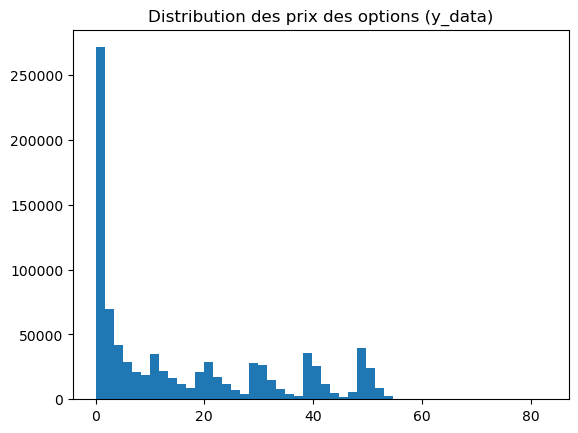

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_data.flatten(), bins=50)
plt.title("Distribution des prix des options (y_data)")
plt.show()

In [ ]:
df_train = pd.DataFrame(X_data, columns=['xi', 'kappa_1', 'eta_1', 'eta_2', 'rho'])
df_train = pd.concat([df_train, pd.DataFrame(y_data)], axis=1)

df_train.to_csv('training_set_N40K_Nsim500.csv', index=False)

### parameter set 1

$\xi = 0.06, \kappa_1 =41.6, \eta_1 = 18.2428, \eta_2 = 3.43, \rho = -0.7$

### parameter set 2

$\xi = 0.1, \kappa_1 = 15.6, \eta_1 = 5.5857, \eta_2 = 2.2867, \rho = -0.4$

### parameter set 3

$\xi = 0.2, \kappa_1 = 54.6, \eta_1 = 31.3496, \eta_2 = 4.5733, \rho = -0.8$

# References

1)  Lorenzo Bergomi. Smile dynamics II. Risk Magazine, 2005

2) Blanka Horvath, Aitor Muguruza, and Mehdi Tomas. Deep learning volatility: a deep neural 
network perspective on pricing and calibration in (rough) volatility models. Quantitativ 
Finance, 21(1):11–27, 20218

3) Ryan McCrickerd and Mikko S Pakkanen. Turbocharging monte carlo pricing for the rough 
bergomi model. Quantitative Finance, 18(11):1877–1886, 2018